### Import packages

In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sb
import scipy.stats as stats
import scipy
import ast
import warnings
import pylab
import matplotlib.pyplot as plt
import math
import pingouin as pg

warnings.filterwarnings('ignore')

### Load & Organize Data

In [2]:
path = 'behavioral_data/MRI_Behavioral_Data/'

Make a list of dataframes for all the runs we use in the MRI analysis

In [3]:
# first, read in the runs and run files we need to ignore

exclude_file    = [ x for x in os.listdir('.') if 'exclude' in x   ]
disregard_files = [ x for x in os.listdir('.') if 'disregard' in x ]
disregard_dfs   = [ pd.read_csv(x).T for x in disregard_files ]

### First, data to exclude

In [4]:
pd.read_csv(exclude_file[0])

,Unnamed: 0,run,count,subject
0,1,2.0,8,behavioral_data/MRI_Behavioral_Data/subject_21
1,2,3.0,15,behavioral_data/MRI_Behavioral_Data/subject_21
2,3,4.0,11,behavioral_data/MRI_Behavioral_Data/subject_21


^^ We will exclude runs 2, 3, and 4 from subject 21

We also exclude subject_17

### Then, log files to ignore

In [5]:
disregard_subs = pd.concat(disregard_dfs)[0].unique()
disregard_subs

array(['subject', 'subject_12', 'subject_4', 'subject_20'], dtype=object)

In [6]:
disregard_logs = pd.concat(disregard_dfs)[1].unique()
disregard_logs

array(['file',
       'behavioral_data/MRI_Behavioral_Data/subject_12/subject_12_run_1_2023-09-01_14h48.28.289.log',
       'behavioral_data/MRI_Behavioral_Data/subject_4/subject_4c_run_1_2023-08-24_13h14.00.218.log',
       'behavioral_data/MRI_Behavioral_Data/subject_20/subjec_20b_run_1_2023-11-02_17h48.21.836.log'],
      dtype=object)

In [7]:
disregard_csvs = [ x[:-4]+'.csv' for x in disregard_logs ]
disregard_csvs

['.csv',
 'behavioral_data/MRI_Behavioral_Data/subject_12/subject_12_run_1_2023-09-01_14h48.28.289.csv',
 'behavioral_data/MRI_Behavioral_Data/subject_4/subject_4c_run_1_2023-08-24_13h14.00.218.csv',
 'behavioral_data/MRI_Behavioral_Data/subject_20/subjec_20b_run_1_2023-11-02_17h48.21.836.csv']

In [8]:
extra_runs = ['behavioral_data/subject_1/sub_1_run_1_2023-08-18_12h17.09.696.csv',
              'behavioral_data/subject_12/subject_12_run_1_2023-09-01_15h08.30.551.csv'
             ]

### Create function to add response type 

In [9]:
def add_type(data):
    # Organize scores
    data['response_type'] = np.nan
    data['response_value'] = np.nan

    # Handle cases with two responses
    if data.loc[data['key_resp_9.keys'].str.contains(',', na=False), 'key_resp_9.keys'].shape[0] > 0:
        data.loc[data['key_resp_9.keys'].str.contains(',', na=False), 'key_resp_9.keys'] = data['key_resp_9.keys'].str.split(',').str[0]

    # Assign response_value based on 'key_resp_9.keys'
    data['response_value'] = data['key_resp_9.keys'].str[2]

    # Set response_type based on conditions
    data.loc[(data['response_value'] == '1') & (data['type'].str.contains('veridical', na=False)), 'response_type'] = 'Hit'
    data.loc[(data['response_value'] == '1') & (data['type'].str.contains('scrambled', na=False)), 'response_type'] = 'False Alarm'
    data.loc[(data['response_value'] == '2') & (data['type'].str.contains('veridical', na=False)), 'response_type'] = 'Miss'
    data.loc[(data['response_value'] == '2') & (data['type'].str.contains('scrambled', na=False)), 'response_type'] = 'Correct Reject'

    # Handle unanswered responses
    data['unanswered'] = data['key_resp_9.keys'].isna() | data['key_resp_9.keys'].str.contains('None', na=False)
    
    return data

In [10]:
# Initialize the list of dataframes
data_dfs = []

# Define your path
base_path = 'behavioral_data/MRI_Behavioral_Data/'

# Iterate over each subject in the behavioral_data directory
for sub in os.listdir(base_path):
    # Check if the folder is a subject and not the excluded subject
    if sub != 'subject_17' and sub.startswith('subject_'):
        # Full path to the subject's directory
        sub_dir = os.path.join(base_path, sub)
        
        # List all csv files in the current subject's directory
        csvs = [
            os.path.join(sub_dir, x) for x in os.listdir(sub_dir)
            if x.endswith('.csv')
            and os.path.join(sub_dir, x) not in disregard_csvs
            and os.path.join(sub_dir, x) not in extra_runs
        ]
        
        # Read them as dataframes and add to data_dfs
        for csv_file in csvs:
            try:
                df = pd.read_csv(csv_file)
                df = add_type(df)  
                data_dfs.append(df)
            except Exception as e:
                print(f"Error reading {csv_file}: {e}")

In [11]:
# Combine all dataframes into one dataframe
new_data = pd.concat(data_dfs, ignore_index=True)

# Correct participant labels
new_data.loc[new_data['participant'] == 'subject_16c3', 'participant'] = 'subject_16c'

# Exclude runs 2, 3, 4 for subject_21 and remove any rows where run is NaN
new_data = new_data[~((new_data['participant'] == 'subject_21') & (new_data['run'].isin([2, 3, 4])))]
new_data = new_data[~new_data['run'].isna()]

unique_participants = new_data[~new_data['participant'].isna()]['participant'].unique()
print(f"Number of unique participants: {len(unique_participants)}")

Number of unique participants: 22


In [12]:
# Initialize 'Video Type' and related columns if they don't already exist
if 'Video Type' not in new_data.columns:
    new_data['Video Type'] = np.nan
if 'Participant Judgement' not in new_data.columns:
    new_data['Participant Judgement'] = np.nan
if 'Judged Correctly' not in new_data.columns:
    new_data['Judged Correctly'] = np.nan

# Populate 'Video Type'
new_data.loc[new_data['response_type'].isin(['Hit', 'Miss']), 'Video Type'] = 'Real Attention'
new_data.loc[new_data['response_type'].isin(['False Alarm', 'Correct Reject']), 'Video Type'] = 'Fake Attention'

# Populate 'Participant Judgement' and 'Judged Correctly'
new_data.loc[new_data['response_type'].isin(['Hit', 'False Alarm']), 'Participant Judgement'] = 'Judged Real'
new_data.loc[new_data['response_type'].isin(['Miss', 'Correct Reject']), 'Participant Judgement'] = 'Judged Fake'
new_data.loc[new_data['response_type'].isin(['Hit', 'Correct Reject']), 'Judged Correctly'] = 'Correct'
new_data.loc[new_data['response_type'].isin(['Miss', 'False Alarm']), 'Judged Correctly'] = 'Wrong'

# Check the output after setting the columns
print(new_data[['participant', 'run', 'response_type', 'Video Type', 'Participant Judgement', 'Judged Correctly']].head(10))

   participant  run   response_type      Video Type Participant Judgement  \
1   subject_4c  2.0     False Alarm  Fake Attention           Judged Real   
2   subject_4c  2.0             Hit  Real Attention           Judged Real   
3   subject_4c  2.0     False Alarm  Fake Attention           Judged Real   
4   subject_4c  2.0             Hit  Real Attention           Judged Real   
5   subject_4c  2.0  Correct Reject  Fake Attention           Judged Fake   
6   subject_4c  2.0             Hit  Real Attention           Judged Real   
7   subject_4c  2.0             Hit  Real Attention           Judged Real   
8   subject_4c  2.0  Correct Reject  Fake Attention           Judged Fake   
9   subject_4c  2.0             NaN             NaN                   NaN   
10  subject_4c  2.0            Miss  Real Attention           Judged Fake   

   Judged Correctly  
1             Wrong  
2           Correct  
3             Wrong  
4           Correct  
5           Correct  
6           Correct 

In [13]:
new_data.to_csv("behavioral_data.csv", index=False)

In [14]:
new_data.shape[0]

2620

In [15]:
1 - (new_data[new_data['response_type'].isna()].shape[0] / new_data[~new_data['response_type'].isna()].shape[0])


0.9741581832419733

### Plot the results

In [16]:
d = new_data.groupby(['participant','response_type'], as_index=False).count()

In [17]:
grouped_by_resp_type = new_data.groupby(['participant','response_type'],as_index=False).count()

<Axes: xlabel='response_type', ylabel='run'>

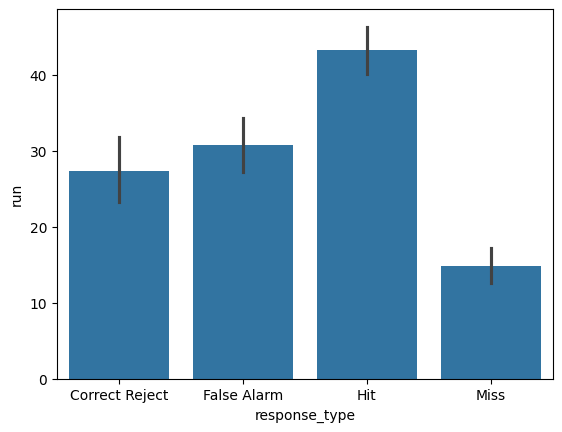

In [18]:
sb.barplot(data=grouped_by_resp_type, x='response_type',y='run')

In [19]:
groupy_plot = new_data.groupby(['participant', 'response_type', 'Participant Judgement', 'Video Type'],as_index=False).count() #.columns

In [20]:
groupy_plot.head()

,participant,response_type,Participant Judgement,Video Type,run,start_time,type,moviestim,jitters,frames,...,session,date,expName,psychopyVersion,frameRate,Unnamed: 31,response_value,unanswered,Unnamed: 30,Judged Correctly
0,Subject_7,Correct Reject,Judged Fake,Fake Attention,43,43,43,43,43,0,...,43,43,43,43,43,0,43,43,0,43
1,Subject_7,False Alarm,Judged Real,Fake Attention,17,17,17,17,17,0,...,17,17,17,17,17,0,17,17,0,17
2,Subject_7,Hit,Judged Real,Real Attention,52,52,52,52,52,0,...,52,52,52,52,52,0,52,52,0,52
3,Subject_7,Miss,Judged Fake,Real Attention,8,8,8,8,8,0,...,8,8,8,8,8,0,8,8,0,8
4,sub_1,Correct Reject,Judged Fake,Fake Attention,57,57,57,57,57,0,...,57,57,57,57,57,0,57,57,0,57


<Axes: xlabel='Video Type', ylabel='run'>

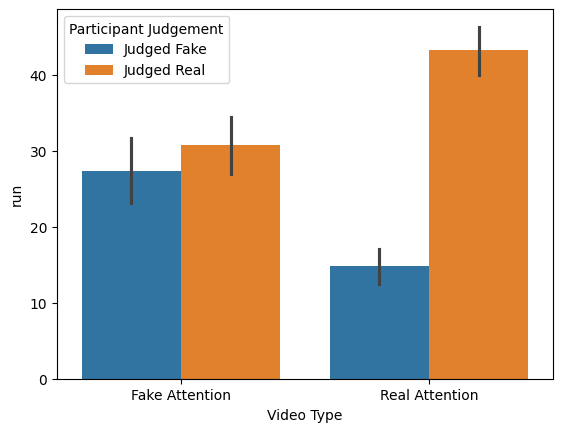

In [21]:
sb.barplot(data=groupy_plot, x='Video Type', y='run', hue='Participant Judgement')

### Performance by Individual Subject

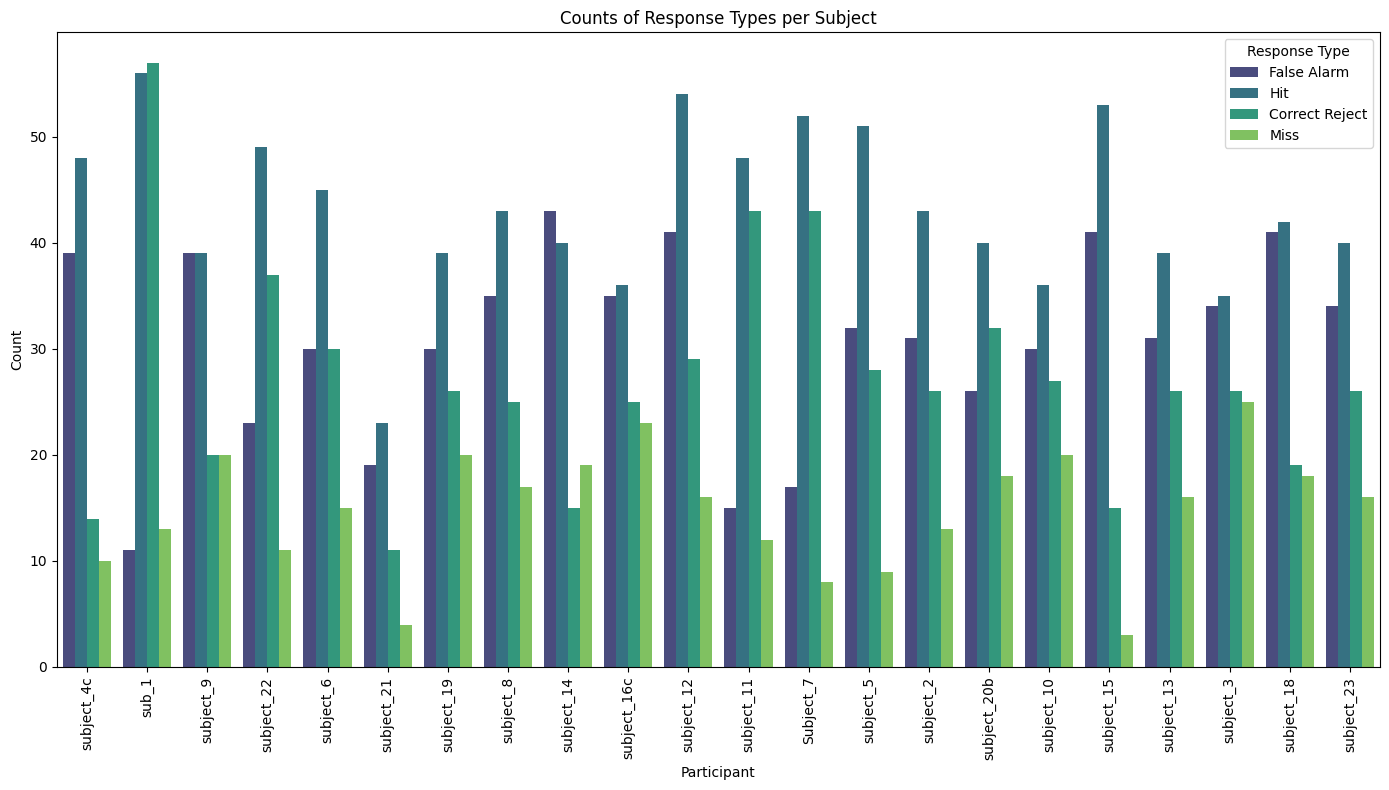

In [74]:
# Set the figure size
plt.figure(figsize=(14, 8))

# Create a count plot with response_type as hue
sb.countplot(data=new_data, x='participant', hue='response_type', order=new_data['participant'].unique(), palette='viridis')

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Set titles and labels
plt.title('Counts of Response Types per Subject')
plt.xlabel('Participant')
plt.ylabel('Count')

# Add legend
plt.legend(title='Response Type')

# Adjust layout to make room for the rotated x-axis labels
plt.tight_layout()

# Save the plot
plt.savefig('all_response_types_per_subject.png')

# Show the plot
plt.show()

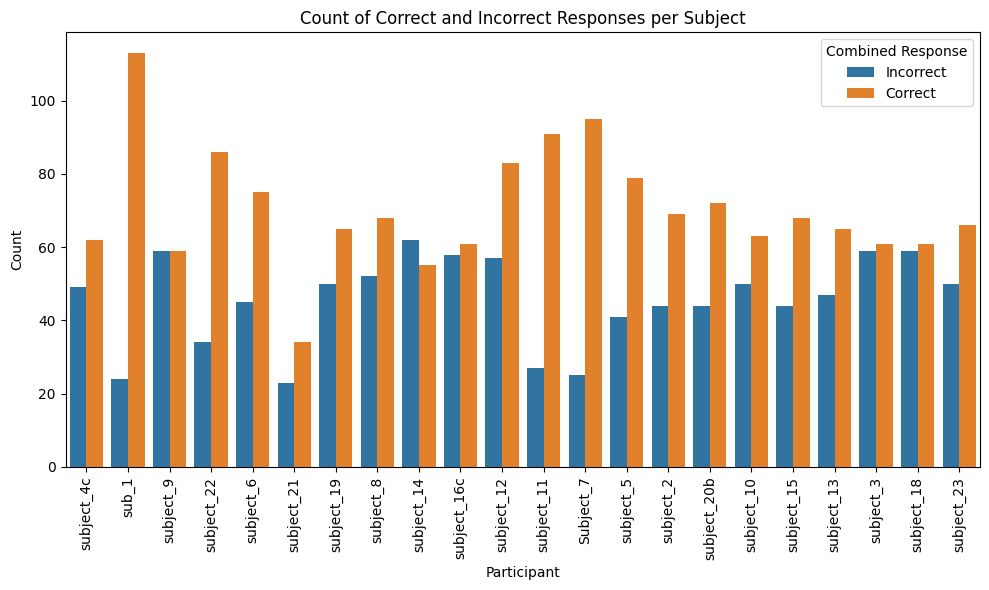

In [75]:
# Combined Counts
combined_data = new_data.copy()
combined_data['Combined Response'] = combined_data['response_type'].replace({
    'Hit': 'Correct',
    'Correct Reject': 'Correct',
    'Miss': 'Incorrect',
    'False Alarm': 'Incorrect'
})

# Plot combined counts
plt.figure(figsize=(10, 6))
sb.countplot(data=combined_data, x='participant', hue='Combined Response', order=new_data['participant'].unique())
plt.xticks(rotation=90)
plt.title('Count of Correct and Incorrect Responses per Subject')
plt.xlabel('Participant')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('combined_responses_per_subject.png')
plt.show()

### Response ANOVA

In [22]:
pg.rm_anova(data=groupy_plot, dv='run', within=['Video Type','Participant Judgement'], subject='participant')

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,Video Type,0.000000,1,21,0.000000,0.000000,1.000000e+00,1.000000e+00,0.000000,1.0
1,Participant Judgement,5600.045455,1,21,5600.045455,68.653868,4.670151e-08,4.670151e-08,0.480798,1.0
2,Video Type * Participant Judgement,3412.545455,1,21,3412.545455,22.819453,1.016538e-04,1.016538e-04,0.360738,1.0


### T-tests

In [23]:
# RR versus RF
print("Real Attention judged Real vs Real Attention judged Fake")
print(scipy.stats.ttest_rel( list(groupy_plot[(groupy_plot['Video Type']=='Real Attention')
                                             &(groupy_plot['Participant Judgement']=='Judged Real')]['run']),
                            
                             list(groupy_plot[(groupy_plot['Video Type']=='Real Attention')
                                             &(groupy_plot['Participant Judgement']=='Judged Fake')]['run']) ))

# RR versus FF
print("Real Attention judged Real vs Fake Attention judged Fake")   
print(scipy.stats.ttest_rel( list(groupy_plot[(groupy_plot['Video Type']=='Real Attention')
                                             &(groupy_plot['Participant Judgement']=='Judged Real')]['run']),
                            
                             list(groupy_plot[(groupy_plot['Video Type']=='Fake Attention')
                                             &(groupy_plot['Participant Judgement']=='Judged Fake')]['run']) ))
      
# RR versus FR
print("Real Attention judged Real vs Fake Attention judged Real")
print(scipy.stats.ttest_rel( list(groupy_plot[(groupy_plot['Video Type']=='Real Attention')
                                             &(groupy_plot['Participant Judgement']=='Judged Real')]['run']),
                            
                             list(groupy_plot[(groupy_plot['Video Type']=='Fake Attention')
                                             &(groupy_plot['Participant Judgement']=='Judged Real')]['run']) ))
      
##########################################

print()
      
## FF versus RF
print("Fake Attention judged Fake vs Real Attention judged Fake")
print(scipy.stats.ttest_rel( list(groupy_plot[(groupy_plot['Video Type']=='Fake Attention')
                                             &(groupy_plot['Participant Judgement']=='Judged Fake')]['run']),
                            
                             list(groupy_plot[(groupy_plot['Video Type']=='Real Attention')
                                             &(groupy_plot['Participant Judgement']=='Judged Fake')]['run']) ))


## FF versus FR
print("Fake Attention judged Fake vs Fake Attention judged Real")
print(scipy.stats.ttest_rel( list(groupy_plot[(groupy_plot['Video Type']=='Fake Attention')
                                             &(groupy_plot['Participant Judgement']=='Judged Fake')]['run']),
                            
                             list(groupy_plot[(groupy_plot['Video Type']=='Fake Attention')
                                             &(groupy_plot['Participant Judgement']=='Judged Real')]['run']) ))

##########################################

print()

## FR versus RF
print("Fake Attention judged Real vs Real Attention judged Fake")
print(scipy.stats.ttest_rel( list(groupy_plot[(groupy_plot['Video Type']=='Fake Attention')
                                             &(groupy_plot['Participant Judgement']=='Judged Real')]['run']),
                            
                             list(groupy_plot[(groupy_plot['Video Type']=='Real Attention')
                                             &(groupy_plot['Participant Judgement']=='Judged Fake')]['run']) ))


Real Attention judged Real vs Real Attention judged Fake
TtestResult(statistic=11.949464076960728, pvalue=7.870689701187852e-11, df=21)
Real Attention judged Real vs Fake Attention judged Fake
TtestResult(statistic=8.121482029980042, pvalue=6.462147437324623e-08, df=21)
Real Attention judged Real vs Fake Attention judged Real
TtestResult(statistic=4.709229371786104, pvalue=0.00011941479611532661, df=21)

Fake Attention judged Fake vs Real Attention judged Fake
TtestResult(statistic=4.81935916341814, pvalue=9.192172219289544e-05, df=21)
Fake Attention judged Fake vs Fake Attention judged Real
TtestResult(statistic=-0.8930947367014539, pvalue=0.38192722798521683, df=21)

Fake Attention judged Real vs Real Attention judged Fake
TtestResult(statistic=8.369238690948817, pvalue=3.9651109104110084e-08, df=21)


We see, above, that real videos judged real are a significantly higher proportion of trials than any other. 

Fake judged fake are also higher than real judged fake.

And, finally, Fake videos judged real are significantly more than real videos judged as fake.

### Let's also obtain / look at the proportion correct

In [24]:
proportion_data = {'data':[], 
                   'type':[],
                   'vid_type':[]
                  }

for p in new_data['participant'].unique():
    
    k_1 = new_data[(new_data['participant']==p) 
                   & ~(new_data['Participant Judgement'].isna())
                   &  (new_data['Video Type']=='Real Attention')
                  ]
    
    k_2 = new_data[(new_data['participant']==p) 
                   & ~(new_data['Participant Judgement'].isna())
                   &  (new_data['Video Type']=='Fake Attention')]
    
    full_shape_1  = k_1.shape[0]
    full_shape_2  = k_2.shape[0]
    
    hit_shape     = k_1[k_1['response_type']=='Hit'].shape[0]
    miss_shape    = k_1[k_1['response_type']=='Miss'].shape[0]
    fa_shape      = k_2[k_2['response_type']=='False Alarm'].shape[0] 
    cr_shape      = k_2[k_2['response_type']=='Correct Reject'].shape[0]

    proportion_data['data'].append(hit_shape/full_shape_1)
    proportion_data['vid_type'].append('Real')
    proportion_data['type'].append('Judged Real')
    
    proportion_data['data'].append(miss_shape/full_shape_1)
    proportion_data['vid_type'].append('Real')
    proportion_data['type'].append('Judged Fake')
    
    proportion_data['data'].append(fa_shape/full_shape_2)
    proportion_data['vid_type'].append('Fake')
    proportion_data['type'].append('Judged Real')
    
    proportion_data['data'].append(cr_shape/full_shape_2)
    proportion_data['vid_type'].append('Fake')
    proportion_data['type'].append('Judged Fake')
    

In [25]:
prop_df = pd.DataFrame(proportion_data)
prop_df.head()

,data,type,vid_type
0,0.827586,Judged Real,Real
1,0.172414,Judged Fake,Real
2,0.735849,Judged Real,Fake
3,0.264151,Judged Fake,Fake
4,0.811594,Judged Real,Real


<Axes: xlabel='vid_type', ylabel='data'>

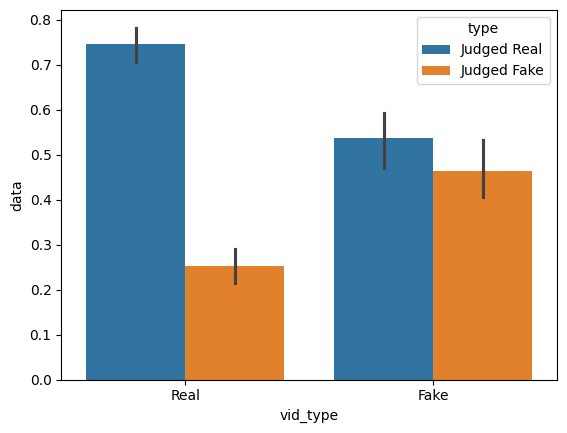

In [26]:
sb.barplot(data=prop_df, x='vid_type', y='data', hue='type')

In [27]:
gr = prop_df.groupby(['vid_type','type'],as_index=False).mean()
gr

,vid_type,type,data
0,Fake,Judged Fake,0.464037
1,Fake,Judged Real,0.535963
2,Real,Judged Fake,0.253357
3,Real,Judged Real,0.746643


### How many "fake" judgements for the average participant?

In [28]:
n  = new_data.groupby(['participant','Participant Judgement'],as_index=False).count()
nn = n[n['Participant Judgement'] == 'Judged Fake'] 

print(nn['run'].mean())
print(nn['run'].std())

42.09090909090909
12.082687697335473


In [29]:
this_list  = list(nn['run'])
this_listo = this_list + [8]

<Axes: ylabel='run'>

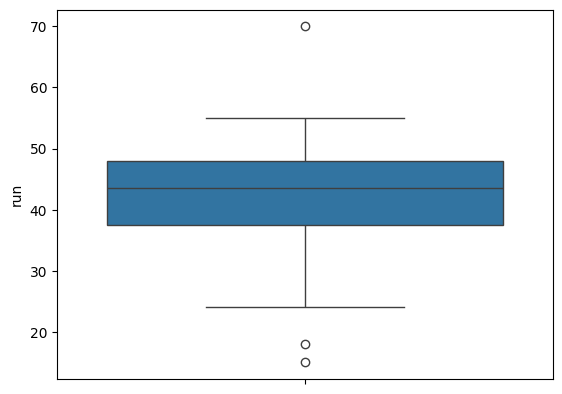

In [30]:
sb.boxplot(nn['run'])

<Axes: >

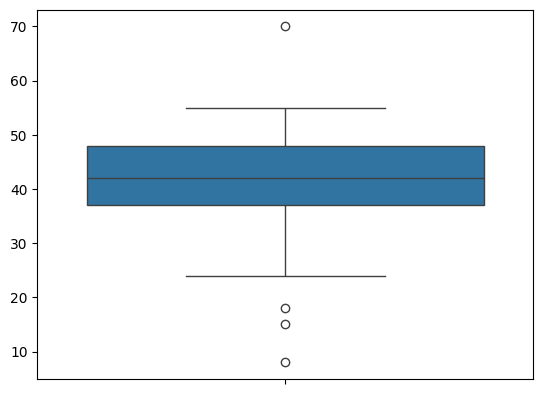

In [31]:
sb.boxplot(this_listo)

### Now, let's plot d-prime

In [32]:
def add_dprime(data):
    '''
    adds dprime column to dataframe with dprime values for each subject
    '''
    
    # make new d-prime column in the data
    data['dprime'] = np.nan
    
    # for each subject in the df:
    for p in data['participant'].unique():
    
        # get the number of trials they responded to
        responses = new_data[~(new_data['response_type'].isna()) & (new_data['participant']==p)].shape[0]
        
        # get number of hits, misses, false alarms, correct rejections
        hit  = new_data[(new_data['response_type']=='Hit') & (new_data['participant']==p)].shape[0]
        miss = new_data[(new_data['response_type']=='Miss') & (new_data['participant']==p)].shape[0]
        fa   = new_data[(new_data['response_type']=='False Alarm') & (new_data['participant']==p)].shape[0]
        cr   = new_data[(new_data['response_type']=='Correct Reject') & (new_data['participant']==p)].shape[0]
        
        # calculate hit rate
        hit_rate = hit / new_data[(new_data['participant']==p)
                                  & (new_data['Video Type']=='Real Attention')
                                  & ~(new_data['response_type'].isna())
                                 ].shape[0]
        
        # calculate false alarm rate
        fa_rate = fa / new_data[(new_data['participant']==p) 
                                & (new_data['Video Type']=='Fake Attention')
                                & ~(new_data['response_type'].isna())
                               ].shape[0]
        
        # calculate d-prime
        d_prime = scipy.stats.norm.ppf(hit_rate) - scipy.stats.norm.ppf(fa_rate)
        
        # add d-prime value to d-prime column for all rows for that participant
        data.loc[data['participant']==p,'dprime'] = d_prime
        
    return(data)

In [33]:
d_prime_data = add_dprime(new_data)

In [34]:
plot_prime = d_prime_data.groupby(['participant'],as_index=False)['dprime'].mean()

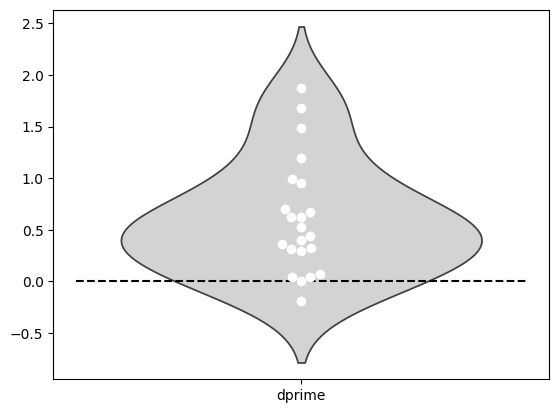

In [35]:
sb.violinplot(plot_prime, inner=None, color='lightgray')
sb.swarmplot(plot_prime, color='white', size=7)
plt.hlines(y=0, xmin=-.5,xmax=.5, color='k', linestyle='--')
plt.savefig('dprime_light.pdf')

In [36]:
scipy.stats.ttest_1samp(plot_prime['dprime'],0)

TtestResult(statistic=5.162937906370936, pvalue=4.083541073224179e-05, df=21)

## D'Prime by Run

In [37]:
def add_dprime_by_run(data):
    '''
    Adds dprime column to dataframe with dprime values for each subject and run
    '''
    # Check if required columns exist
    required_columns = ['participant', 'run', 'response_type', 'Video Type']
    missing_columns = [col for col in required_columns if col not in data.columns]
    
    if missing_columns:
        raise KeyError(f"Missing required columns: {missing_columns}")

    dprime_by_run = []

    for p in data['participant'].unique():
        for r in data['run'].unique():
            # Filter data for the specific participant and run
            subset = data[(data['participant'] == p) & (data['run'] == r)]
            
            # Skip if subset is empty
            if subset.empty:
                continue

            try:
                # Get number of trials, hits, misses, false alarms, and correct rejections
                hit = subset[subset['response_type'] == 'Hit'].shape[0]
                miss = subset[subset['response_type'] == 'Miss'].shape[0]
                fa = subset[subset['response_type'] == 'False Alarm'].shape[0]
                cr = subset[subset['response_type'] == 'Correct Reject'].shape[0]
                
                # Calculate hit rate
                hit_rate = hit / subset[(subset['Video Type'] == 'Real Attention')].shape[0] if subset[(subset['Video Type'] == 'Real Attention')].shape[0] > 0 else 0.5

                # Calculate false alarm rate
                fa_rate = fa / subset[(subset['Video Type'] == 'Fake Attention')].shape[0] if subset[(subset['Video Type'] == 'Fake Attention')].shape[0] > 0 else 0.5

                # Calculate d-prime
                d_prime = scipy.stats.norm.ppf(hit_rate) - scipy.stats.norm.ppf(fa_rate)
                
                # Append d-prime values to the list
                dprime_by_run.append({'participant': p, 'run': r, 'dprime': d_prime})
            
            except KeyError as e:
                print(f"KeyError for participant {p} and run {r}: {e}")
                continue
            except Exception as e:
                print(f"Error calculating d-prime for participant {p} and run {r}: {e}")
                continue
    
    # Convert list to DataFrame
    dprime_by_run_df = pd.DataFrame(dprime_by_run)
    
    return dprime_by_run_df


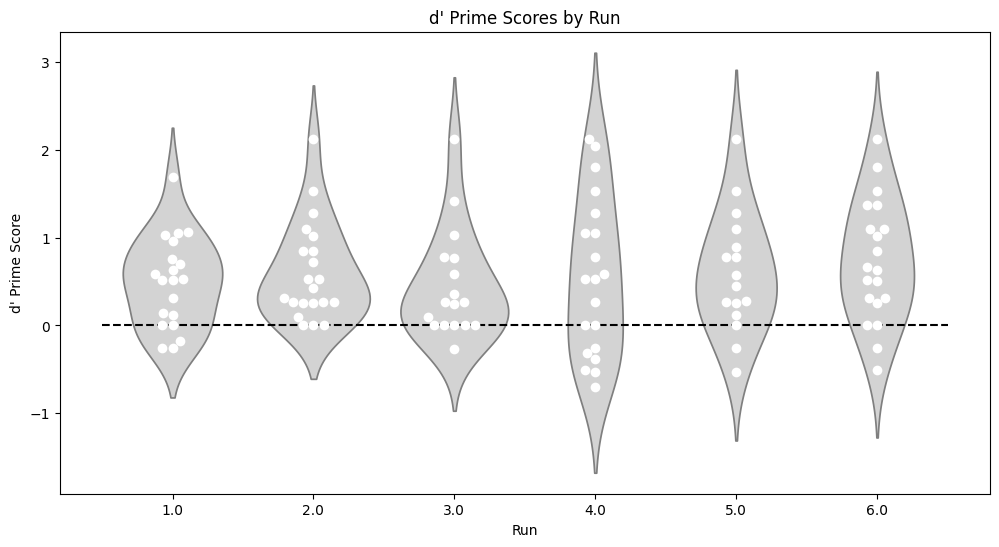

In [38]:
# Calculate d'prime scores by run
d_prime_by_run_data = add_dprime_by_run(new_data)

# Plot d'prime scores by run
plt.figure(figsize=(12, 6))
sb.violinplot(x='run', y='dprime', data=d_prime_by_run_data, inner=None, color='lightgray')
sb.swarmplot(x='run', y='dprime', data=d_prime_by_run_data, color='white', size=7)
plt.hlines(y=0, xmin=-0.5, xmax=5.5, color='k', linestyle='--')
plt.xlabel('Run')
plt.ylabel("d' Prime Score")
plt.title("d' Prime Scores by Run")
plt.savefig('dprime_by_run.pdf')
plt.show()

### Reaction times for "fake" and "real" judgements

In [39]:
x = new_data.groupby(['participant','response_value'],as_index=False).mean(['participant'])

In [40]:
list(new_data['key_resp_9.rt'][1])[0]

'['

In [41]:
reaction_times = []

for orig in list(new_data['key_resp_9.rt']):
    
    if type(orig) == str:
        reaction_times.append(float(orig[1:-1].split(', ')[0]))
    else:
        reaction_times.append(orig)

# rts = [ x[1:17] for x in list(new_data['key_resp_9.rt']) if len(x) > 0]

In [42]:
new_data['single_rt'] = reaction_times

In [43]:
dat = new_data.groupby(['participant','response_value'],as_index=False).mean('?')[['participant','response_value','single_rt']]

<Axes: xlabel='response_value', ylabel='single_rt'>

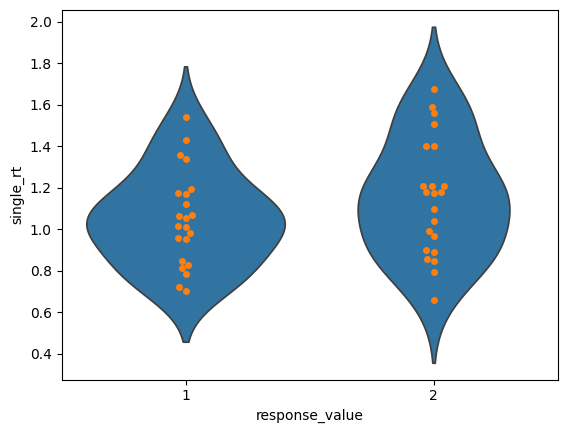

In [44]:
sb.violinplot(data=dat, x='response_value', y='single_rt', inner=None)
sb.swarmplot(data=dat, x='response_value', y='single_rt')

<Axes: xlabel='response_type', ylabel='single_rt'>

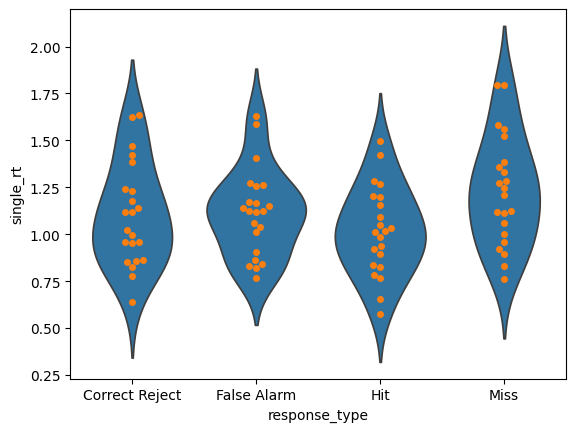

In [45]:
dat = new_data.groupby(['participant','response_type','response_value','type'],as_index=False).mean('?')[['participant','response_type','response_value','single_rt','type']]

#dat = new_data.groupby(['participant','response_value'],as_index=False).mean('?')[['participant','response_value','single_rt']]

sb.violinplot(data=dat, x='response_type', y='single_rt', inner=None)
sb.swarmplot(data=dat, x='response_type', y='single_rt')

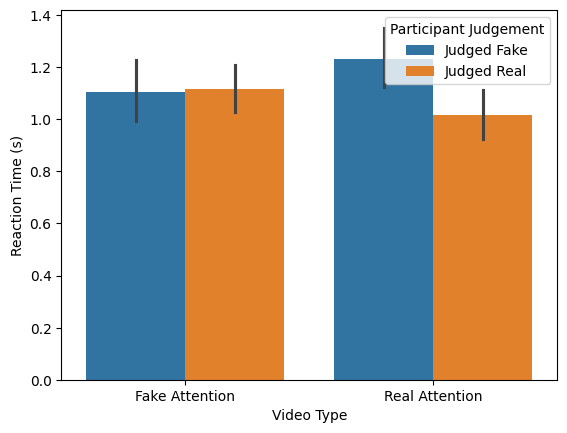

In [46]:
dat['Participant Judgement'] = np.nan
dat.loc[dat['response_value']=='1','Participant Judgement'] = 'Judged Real'
dat.loc[dat['response_value']=='2','Participant Judgement'] = 'Judged Fake'

ax = sb.barplot(data=dat, hue='Participant Judgement', y='single_rt', x='type')

ax.set_xticklabels(['Fake Attention','Real Attention']) 
ax.set_ylabel('Reaction Time (s)') 
ax.set_xlabel('Video Type') 

plt.savefig('reaction_time.pdf',bbox_inches='tight')


### Reaction time ANOVA

In [47]:
import pingouin as pg
pg.rm_anova(data=dat, dv='single_rt', within=['response_value','type'], subject='participant')

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,response_value,0.224014,1,21,0.224014,9.589543,0.005464,0.005464,0.037993,1.0
1,type,0.005527,1,21,0.005527,0.488591,0.492226,0.492226,0.000973,1.0
2,response_value * type,0.284841,1,21,0.284841,22.855968,0.000101,0.000101,0.047816,1.0


In [48]:
print('Judged Real'); print()
print(new_data[new_data['response_type'].isin(['Hit','False Alarm'])]['single_rt'].mean())
print(new_data[new_data['response_type'].isin(['Hit','False Alarm'])]['single_rt'].std())

Judged Real

1.0390561133264287
0.5441554086166496


In [49]:
print('Judged Fake'); print()
print(new_data[new_data['response_type'].isin(['Miss','Correct Reject'])]['single_rt'].mean())
print(new_data[new_data['response_type'].isin(['Miss','Correct Reject'])]['single_rt'].std())

Judged Fake

1.134368105619125
0.5966731693523414


### RT difference between fake vids judged real versus judged fake

In [50]:
a = new_data[new_data['response_type']=='Correct Reject']['single_rt'].mean()
b = new_data[new_data['response_type']=='False Alarm']['single_rt'].mean()

b-a

0.024117539816596922

### do follow-up t-test...

In [51]:
print('Hit versus Miss:')
print(scipy.stats.ttest_rel(list(dat[dat['response_type']=='Hit']['single_rt']),
                      list(dat[dat['response_type']=='Miss']['single_rt'])))
print()


print('Hit versus False Alarm:')
print(scipy.stats.ttest_rel(list(dat[dat['response_type']=='Hit']['single_rt']),
                      list(dat[dat['response_type']=='False Alarm']['single_rt']))); print()

print('Hit versus False Correct Rejection:')
print(scipy.stats.ttest_rel(list(dat[dat['response_type']=='Hit']['single_rt']),
                      list(dat[dat['response_type']=='Correct Reject']['single_rt'])));print()

######################

print('Miss versus Correct Rejection:')
print(scipy.stats.ttest_rel(list(dat[dat['response_type']=='Miss']['single_rt']),
                      list(dat[dat['response_type']=='Correct Reject']['single_rt']))); print()

print('Miss versus False Alarm:')
print(scipy.stats.ttest_rel(list(dat[dat['response_type']=='Miss']['single_rt']),
                      list(dat[dat['response_type']=='False Alarm']['single_rt']))); print()

######################

print('Correct Rejection versus False Alarm:')
print(scipy.stats.ttest_rel(list(dat[dat['response_type']=='Correct Reject']['single_rt']),
                      list(dat[dat['response_type']=='False Alarm']['single_rt']))); print()

print()
print()

######################

print(scipy.stats.ttest_rel(list(dat[dat['response_type']=='Correct Reject']['single_rt']),
                      list(dat[dat['response_type']=='False Alarm']['single_rt']))); print()

Hit versus Miss:
TtestResult(statistic=-5.582441078191904, pvalue=1.536354902686585e-05, df=21)

Hit versus False Alarm:
TtestResult(statistic=-2.776702475026827, pvalue=0.011304278662638811, df=21)

Hit versus False Correct Rejection:
TtestResult(statistic=-2.462693976237436, pvalue=0.02251742312491649, df=21)

Miss versus Correct Rejection:
TtestResult(statistic=4.280447729825837, pvalue=0.0003322716705941898, df=21)

Miss versus False Alarm:
TtestResult(statistic=2.6379425137315513, pvalue=0.015380071276403114, df=21)

Correct Rejection versus False Alarm:
TtestResult(statistic=-0.3054520628961975, pvalue=0.763029023596475, df=21)



TtestResult(statistic=-0.3054520628961975, pvalue=0.763029023596475, df=21)



# check the number of times viewers appeared in the stimuli

In [53]:
movies = [ x for x in list(new_data[~new_data['moviestim'].isna()]['moviestim'].unique()) if 'veridical' in x ]
movies = [ x.split('.bmp_')[1] for x in movies ]
movies = [ x.split('_L')[0] for x in movies ]

In [54]:
def find_duplicates(my_list):
  """
  This function finds duplicate items in a list and prints the item and the number of times it appears.

  Args:
      my_list: A list of any data type.

  Returns:
      None
  """
  counts = {}
  for item in my_list:
    if item in counts:
      counts[item] += 1
    else:
      counts[item] = 1
  for item, count in counts.items():
    #if count > 1:
    print(f"{item} appears {count} times")

In [55]:
find_duplicates(movies)

pp84 appears 2 times
pp152 appears 2 times
pp97 appears 3 times
pp98 appears 1 times
pp63 appears 2 times
pp151 appears 3 times
pp58 appears 2 times
pp54 appears 3 times
pp80 appears 2 times
pp90 appears 2 times
pp89 appears 3 times
pp64 appears 3 times
pp82 appears 2 times
pp51 appears 1 times
pp99 appears 2 times
pp53 appears 1 times
pp75 appears 1 times
pp94 appears 2 times
pp69 appears 2 times
pp93 appears 2 times
pp67 appears 2 times
pp79 appears 1 times
pp86 appears 2 times
pp56 appears 1 times
pp60 appears 2 times
pp81 appears 1 times
pp91 appears 3 times
pp65 appears 1 times
pp76 appears 1 times
pp73 appears 1 times
pp100 appears 1 times
pp95 appears 1 times
pp88 appears 1 times
pp57 appears 1 times


In [56]:
len(set(movies))

34

In [57]:
len(movies)

60

# Analyze performance based on stimuli

In [58]:
# Define response types and their correctness
correct_responses = {'Hit', 'Correct Reject'}
wrong_responses = {'Miss', 'False Alarm'}

# Add a column to indicate whether the response is correct or wrong
new_data['is_correct'] = new_data['response_type'].apply(lambda x: x in correct_responses)

# Group by stimulus and response type, and count occurrences
performance_summary = new_data.groupby(['moviestim', 'response_type']).size().unstack(fill_value=0)

# Calculate the number of correct and wrong responses
performance_summary['correct'] = new_data[new_data['is_correct']].groupby('moviestim').size()
performance_summary['wrong'] = new_data[~new_data['is_correct']].groupby('moviestim').size()

# Fill NaN values with 0
performance_summary.fillna(0, inplace=True)

# Calculate total responses and accuracy for each stimulus
performance_summary['total_responses'] = performance_summary[['Hit', 'Correct Reject', 'Miss', 'False Alarm']].sum(axis=1)
performance_summary['accuracy'] = performance_summary['correct'] / performance_summary['total_responses']

# Display the performance summary
print("Detailed Performance Metrics:")
print(performance_summary[['Hit', 'Correct Reject', 'Miss', 'False Alarm', 'correct', 'wrong', 'total_responses', 'accuracy']])

Detailed Performance Metrics:
response_type                                       Hit  Correct Reject  Miss  \
moviestim                                                                       
fps_60/1159318.bmp_pp93_L1_V1_scrambled_freevie...    0              12     0   
fps_60/1159318.bmp_pp93_L1_V1_veridical_freevie...   16               0     6   
fps_60/1159325.bmp_pp67_L2_V1_scrambled_freevie...    0              11     0   
fps_60/1159325.bmp_pp67_L2_V1_veridical_freevie...   14               0     8   
fps_60/1159329.bmp_pp95_L2_V1_scrambled_freevie...    0              10     0   
...                                                 ...             ...   ...   
fps_60/713519.bmp_pp84_L3_V1_veridical_freeview...   13               0     6   
fps_60/713707.bmp_pp63_L1_V1_scrambled_freeview...    0              12     0   
fps_60/713707.bmp_pp63_L1_V1_veridical_freeview...   15               0     6   
fps_60/713807.bmp_pp152_L2_V1_scrambled_freevie...    0              12     0  

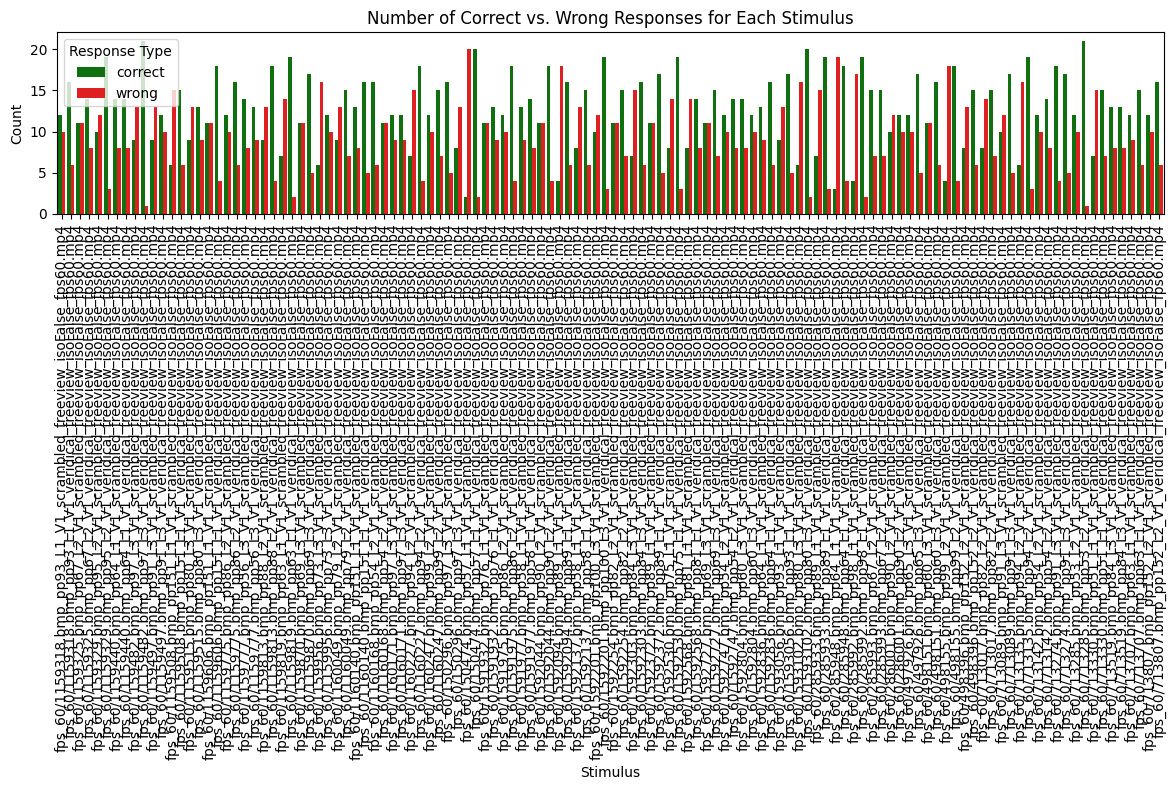

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare data for plotting
plot_data = performance_summary[['correct', 'wrong']].reset_index()
plot_data = plot_data.melt(id_vars='moviestim', var_name='response_type', value_name='count')

# Create a bar plot for correct and wrong responses
plt.figure(figsize=(12, 8))
sns.barplot(data=plot_data, x='moviestim', y='count', hue='response_type', palette={'correct': 'green', 'wrong': 'red'})
plt.xticks(rotation=90)
plt.xlabel('Stimulus')
plt.ylabel('Count')
plt.title('Number of Correct vs. Wrong Responses for Each Stimulus')
plt.legend(title='Response Type')
plt.tight_layout()
plt.show()

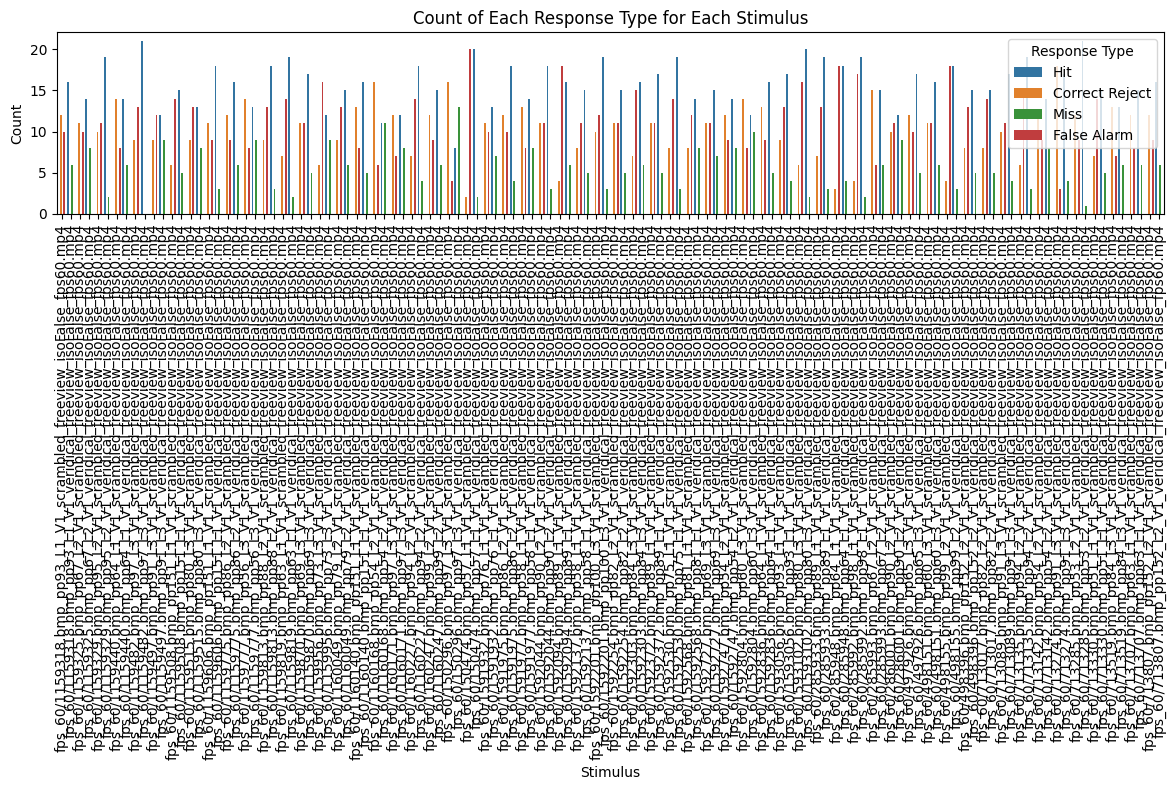

In [60]:
# Prepare data for plotting
plot_data = performance_summary[['Hit', 'Correct Reject', 'Miss', 'False Alarm']].reset_index()
plot_data = plot_data.melt(id_vars='moviestim', var_name='response_type', value_name='count')

# Create a grouped bar plot
plt.figure(figsize=(12, 8))
sns.barplot(data=plot_data, x='moviestim', y='count', hue='response_type')
plt.xticks(rotation=90)
plt.xlabel('Stimulus')
plt.ylabel('Count')
plt.title('Count of Each Response Type for Each Stimulus')
plt.legend(title='Response Type')
plt.tight_layout()
plt.show()

In [61]:
# Assuming 'performance_summary' DataFrame from previous code
# Calculate the percentage of correct responses
performance_summary['percentage_correct'] = (performance_summary['correct'] / performance_summary['total_responses']) * 100

# Identify good stimuli (more than 80% correct responses)
good_stimuli = performance_summary[performance_summary['percentage_correct'] > 80]

# Identify bad stimuli (less than 20% correct responses)
bad_stimuli = performance_summary[performance_summary['percentage_correct'] < 20]

# Display good and bad stimuli
print("Good Stimuli (more than 80% correct responses):")
print(good_stimuli[['correct', 'total_responses', 'percentage_correct']])
print("\nBad Stimuli (less than 20% correct responses):")
print(bad_stimuli[['correct', 'total_responses', 'percentage_correct']])

Good Stimuli (more than 80% correct responses):
response_type                                       correct  total_responses  \
moviestim                                                                      
fps_60/1159329.bmp_pp95_L2_V1_veridical_freevie...       19               21   
fps_60/1159482.bmp_pp97_L3_V1_veridical_freevie...       21               21   
fps_60/1159606.bmp_pp151_L1_V1_veridical_freevi...       18               21   
fps_60/1159813.bmp_pp88_L2_V1_veridical_freevie...       18               21   
fps_60/1159819.bmp_pp63_L1_V1_veridical_freevie...       19               21   
fps_60/1160227.bmp_pp94_L2_V1_veridical_freevie...       18               22   
fps_60/150474.bmp_pp57_L1_V1_veridical_freeview...       20               22   
fps_60/1591975.bmp_pp86_L2_V1_veridical_freevie...       18               22   
fps_60/1592044.bmp_pp90_L2_V1_veridical_freevie...       18               21   
fps_60/1592201.bmp_pp100_L3_V1_veridical_freevi...       19             

In [62]:
# Filter the original data for good and bad stimuli
good_stimuli_data = new_data[new_data['moviestim'].isin(good_stimuli.index)]
bad_stimuli_data = new_data[new_data['moviestim'].isin(bad_stimuli.index)]

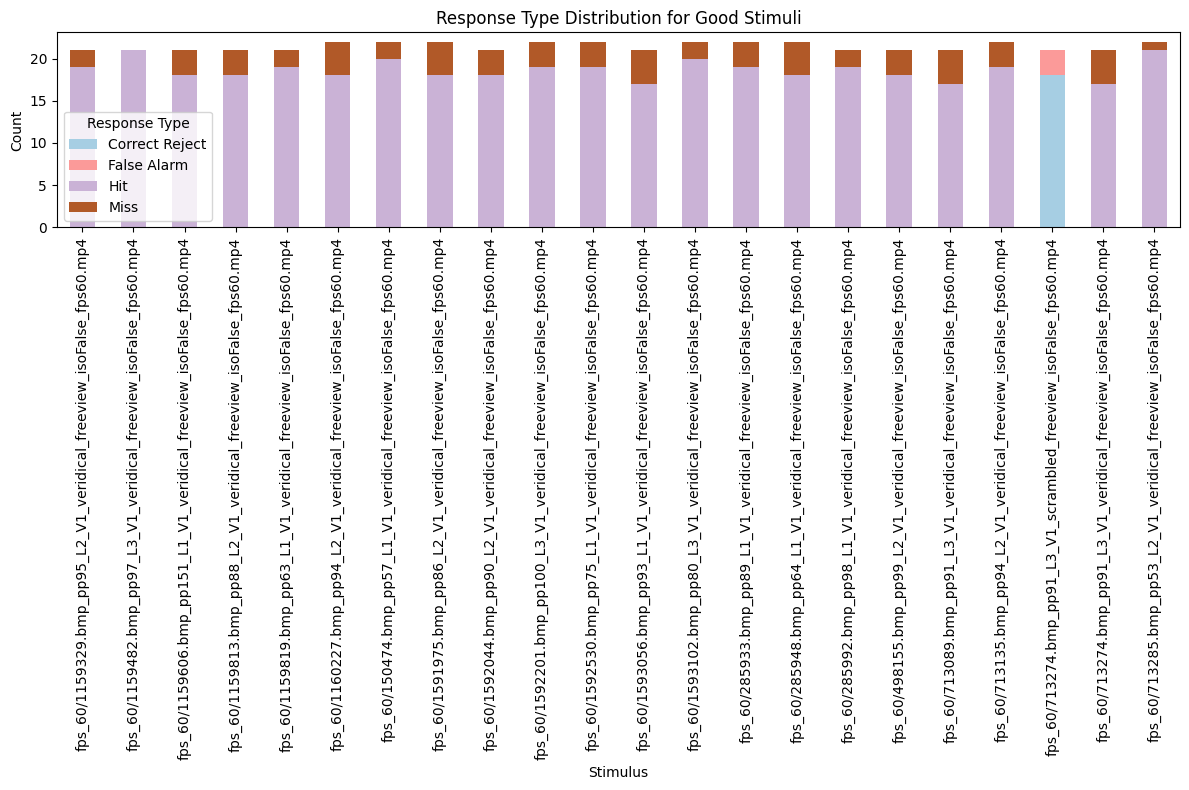

In [63]:
# Prepare data for plotting good stimuli
good_plot_data = good_stimuli_data.groupby(['moviestim', 'response_type']).size().unstack(fill_value=0)
good_plot_data = good_plot_data.reset_index()

# Plot good stimuli
plt.figure(figsize=(12, 8))
good_plot_data.set_index('moviestim').plot(kind='bar', stacked=True, colormap='Paired', ax=plt.gca())
plt.xlabel('Stimulus')
plt.ylabel('Count')
plt.title('Response Type Distribution for Good Stimuli')
plt.legend(title='Response Type')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


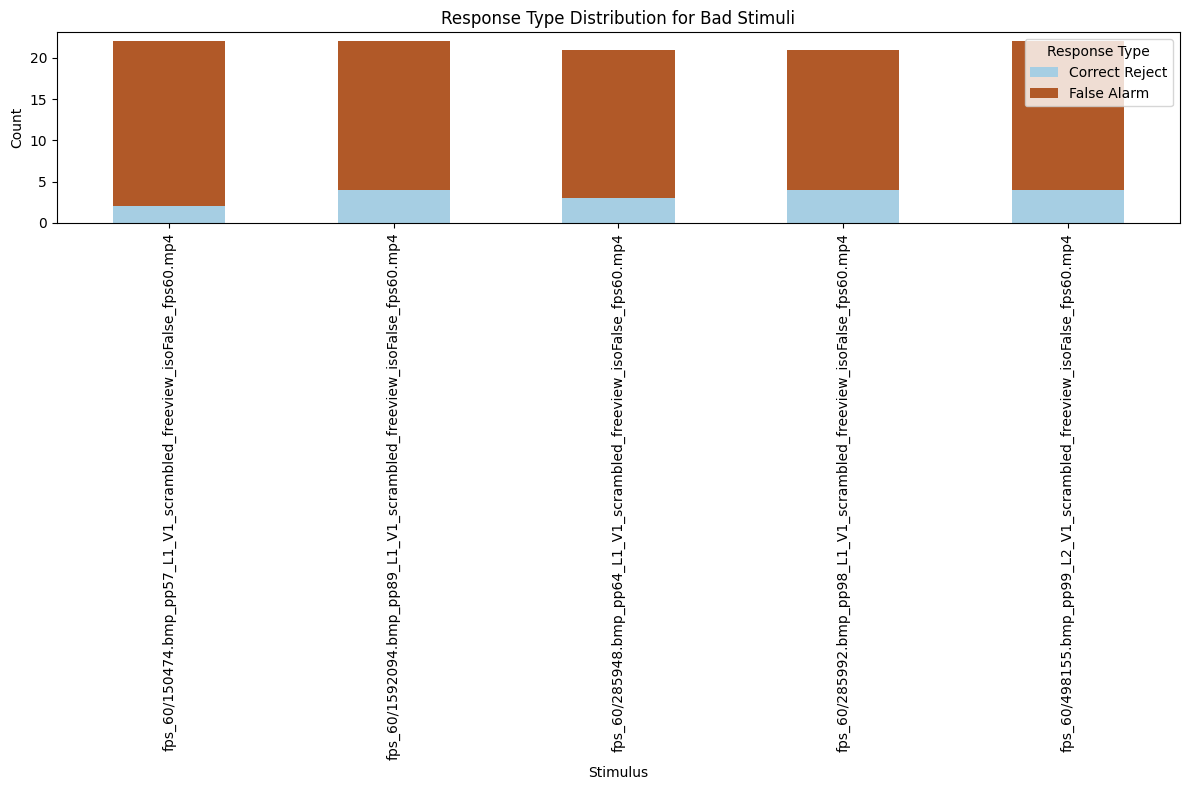

In [64]:
# Prepare data for plotting bad stimuli
bad_plot_data = bad_stimuli_data.groupby(['moviestim', 'response_type']).size().unstack(fill_value=0)
bad_plot_data = bad_plot_data.reset_index()

# Plot bad stimuli
plt.figure(figsize=(12, 8))
bad_plot_data.set_index('moviestim').plot(kind='bar', stacked=True, colormap='Paired', ax=plt.gca())
plt.xlabel('Stimulus')
plt.ylabel('Count')
plt.title('Response Type Distribution for Bad Stimuli')
plt.legend(title='Response Type')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# GRAVEYARD

## Make stimulus timing files for button presses

In [ ]:
df[~df['key_resp_9.rt'].isna()].head(n=2)

In [ ]:
# import the log files
log_files = [x for x in os.listdir('/Users/kirstenziman/Documents/predicting_attention_MRI/MRI_pilot/task/MRI_behavioral/') if '.csv' in x]

# concatenate big dataframe with the data
df = pd.concat([pd.read_csv('/Users/kirstenziman/Documents/predicting_attention_MRI/MRI_pilot/task/MRI_behavioral/'+x) for x in log_files])

# groupby participant and run #
df.groupby(['participant','session'],as_index=False).mean()

# calculate the videoduration
# NOTE: these timesare super weird, need to chech if the MRI machine is dropping frames or what the heck is going on
df['video_duration'] = df['text_15.started'] - df['movie.started'] 

# plot recorded video times
sb.histplot(df['video_duration'])

In [ ]:
# make columnswith start times for each button press
df['key_rt'] = np.nan
df.loc[~df['key_resp_9.rt'].isna(),'key_rt'] = [ast.literal_eval(x)[0] for x in df[~df['key_resp_9.rt'].isna()]['key_resp_9.rt']]
df['button_start_scan'] = df['start_time'] + df['video_duration'] + df['key_rt']


# save them out to separate .1D files
for sub in df['participant'].unique():
    new_df={}
    for sess in [1.0,2.0,3.0,4.0,5.0,6.0]:
        new_df[sess]=df[(df['participant']==sub)&(df['session']==sess)
           &(~df['button_start_scan'].isna())]['button_start_scan']
    print('-----------------------------')    
    print(sub)
    print('-----------------------------')
    print(pd.DataFrame(new_df).T)
    pd.DataFrame(new_df).T.to_csv(str(sub)+'.1D',index=False, header=False)
    print('+++++++++++++++++++++++++++++')

In [ ]:
pd.DataFrame(new_df).T

In [ ]:
# df[~(df['key_resp_9.rt'].isna())]['key_rt']

# f = [ast.literal_eval(x)[0] for x in df[~df['key_resp_9.rt'].isna()]['key_resp_9.rt']]
# f

In [ ]:
# df['button_start_scan'] = df['start_time'] + df['video_duration'] + df['key_rt']
# df['button_start_scan']

In [ ]:
# log_files[0]

In [ ]:
# pd.read_csv('/Users/kirstenziman/Documents/predicting_attention_MRI/MRI_pilot/task/MRI_behavioral/'+log_files[0])